In [1]:
!pip install xgboost imbalanced-learn -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                              f1_score, roc_auc_score, confusion_matrix,
                              classification_report, roc_curve)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')
import joblib

In [3]:
from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f"✓ Uploaded: {filename}")

Saving eff.csv to eff.csv
✓ Uploaded: eff.csv


In [4]:
df = pd.read_csv(filename)


print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst 5 rows:")
print(df.head())



Shape: 72629 rows, 43 columns

First 5 rows:
   Employee ID  Age  Years at Company  Monthly Income  Number of Promotions  \
0         8410   31                19            5390                     2   
1        64756   59                 4            5534                     3   
2        30257   24                10            8159                     0   
3        65791   36                 7            3989                     1   
4        65026   56                41            4821                     0   

   Distance from Home  Number of Dependents  Company Tenure (In Months)  \
0                22.0                     0                        89.0   
1                21.0                     3                        21.0   
2                11.0                     3                        74.0   
3                27.0                     2                        50.0   
4                71.0                     0                        68.0   

   Gender_Male  Job Role_Fina

In [5]:

print("Dataset Info:")
print(df.info())
print("\nDataset Summary:")
display(df.describe(include='all').T.head(10))

print("\nColumn Names:")
print(df.columns.tolist())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72629 entries, 0 to 72628
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Employee ID                          72629 non-null  int64  
 1   Age                                  72629 non-null  int64  
 2   Years at Company                     72629 non-null  int64  
 3   Monthly Income                       72629 non-null  int64  
 4   Number of Promotions                 72629 non-null  int64  
 5   Distance from Home                   72629 non-null  float64
 6   Number of Dependents                 72629 non-null  int64  
 7   Company Tenure (In Months)           72629 non-null  float64
 8   Gender_Male                          72629 non-null  int64  
 9   Job Role_Finance                     72629 non-null  int64  
 10  Job Role_Healthcare                  72629 non-null  int64  
 11  Job Role_Media

,count,mean,std,min,25%,50%,75%,max
Employee ID,72629.0,37265.866789,21500.892923,1.0,18645.0,37278.0,55905.0,74498.0
Age,72629.0,38.365653,12.049794,18.0,28.0,38.0,49.0,59.0
Years at Company,72629.0,15.437456,11.012930,1.0,7.0,13.0,22.0,47.0
Monthly Income,72629.0,7290.909031,2141.804633,1226.0,5650.0,7343.0,8867.0,13705.0
Number of Promotions,72629.0,0.831913,0.994297,0.0,0.0,1.0,2.0,4.0
Distance from Home,72629.0,49.999876,28.195123,1.0,26.0,50.0,74.0,99.0
Number of Dependents,72629.0,1.650594,1.553493,0.0,0.0,1.0,3.0,6.0
Company Tenure (In Months),72629.0,55.776095,25.582743,2.0,36.0,56.0,76.0,132.0
Gender_Male,72629.0,0.548018,0.497692,0.0,0.0,1.0,1.0,1.0
Job Role_Finance,72629.0,0.139930,0.346917,0.0,0.0,0.0,0.0,1.0



Column Names:
['Employee ID', 'Age', 'Years at Company', 'Monthly Income', 'Number of Promotions', 'Distance from Home', 'Number of Dependents', 'Company Tenure (In Months)', 'Gender_Male', 'Job Role_Finance', 'Job Role_Healthcare', 'Job Role_Media', 'Job Role_Technology', 'Work-Life Balance_Fair', 'Work-Life Balance_Good', 'Work-Life Balance_Poor', 'Job Satisfaction_Low', 'Job Satisfaction_Medium', 'Job Satisfaction_Very High', 'Performance Rating_Below Average', 'Performance Rating_High', 'Performance Rating_Low', 'Overtime_Yes', 'Education Level_Bachelorâ€™s Degree', 'Education Level_High School', 'Education Level_Masterâ€™s Degree', 'Education Level_PhD', 'Marital Status_Married', 'Marital Status_Single', 'Job Level_Mid', 'Job Level_Senior', 'Company Size_Medium', 'Company Size_Small', 'Remote Work_Yes', 'Leadership Opportunities_Yes', 'Innovation Opportunities_Yes', 'Company Reputation_Fair', 'Company Reputation_Good', 'Company Reputation_Poor', 'Employee Recognition_Low', 'Emplo

In [6]:

if 'Attrition_Stayed' not in df.columns:
    raise ValueError(" Target column 'Attrition_Stayed' not found!")


if 'Employee ID' in df.columns:
    df = df.drop('Employee ID', axis=1)


X = df.drop('Attrition_Stayed', axis=1)
y = df['Attrition_Stayed'
]
print("Features and target separated.")
print("X shape:", X.shape)
print("y shape:", y.shape)

✅ Features and target separated.
X shape: (72629, 41)
y shape: (72629,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y    )

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training target distribution:")
print(y_train.value_counts(normalize=True))



Training set shape: (58103, 41)
Testing set shape: (14526, 41)
Training target distribution:
Attrition_Stayed
1    0.522365
0    0.477635
Name: proportion, dtype: float64


In [8]:

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:" , y_train.value_counts())
print("\nAfter SMOTE:",y_train_res.value_counts())


Before SMOTE: Attrition_Stayed
1    30351
0    27752
Name: count, dtype: int64

After SMOTE: Attrition_Stayed
0    30351
1    30351
Name: count, dtype: int64


In [14]:

models_params = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100],
            'max_depth': [10, None],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    }
}



In [23]:
best_models = {}

for name, mp in models_params.items():
    print(f"\n Running Grid Search for {name}...")

    grid = GridSearchCV(
        estimator=mp['model'],
        param_grid=mp['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=2
    )

    grid.fit(X_train, y_train)

    print(f" Best score for {name}: {grid.best_score_:.4f}")
    print(f" Best params for {name}: {grid.best_params_}")

    best_models[name] = grid.best_estimator_



 Running Grid Search for RandomForest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best score for RandomForest: 0.7467
 Best params for RandomForest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

 Running Grid Search for GradientBoosting...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best score for GradientBoosting: 0.7543
 Best params for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

 Running Grid Search for XGBoost...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best score for XGBoost: 0.7560
 Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

evaluation = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    evaluation.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    })

eval_df = pd.DataFrame(evaluation)
eval_df


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,RandomForest,0.750034,0.753686,0.774644,0.764022,0.838859
1,GradientBoosting,0.759053,0.769515,0.769109,0.769312,0.852026
2,XGBoost,0.759603,0.772703,0.764760,0.768711,0.852101


In [28]:
from sklearn.metrics import confusion_matrix

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"Model: {name}")
    print("Confusion Matrix:")
    print(cm)
    print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")
    print("-" * 50)


Model: RandomForest
Confusion Matrix:
[[5017 1921]
 [1710 5878]]
True Negatives: 5017, False Positives: 1921, False Negatives: 1710, True Positives: 5878
--------------------------------------------------
Model: GradientBoosting
Confusion Matrix:
[[5190 1748]
 [1752 5836]]
True Negatives: 5190, False Positives: 1748, False Negatives: 1752, True Positives: 5836
--------------------------------------------------
Model: XGBoost
Confusion Matrix:
[[5231 1707]
 [1785 5803]]
True Negatives: 5231, False Positives: 1707, False Negatives: 1785, True Positives: 5803
--------------------------------------------------


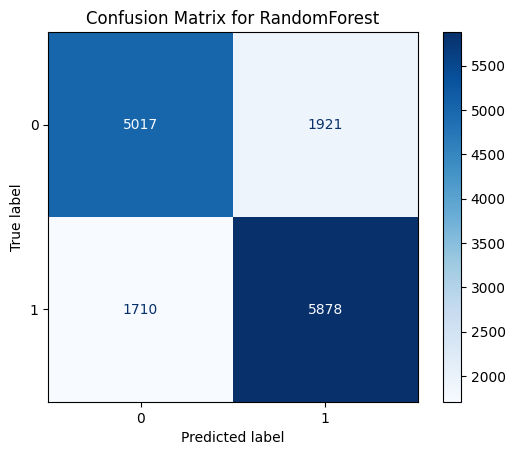

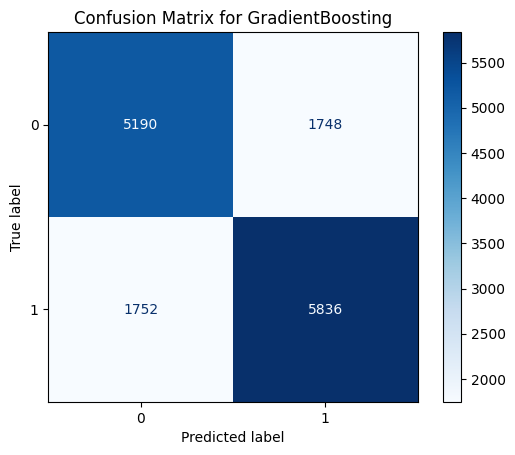

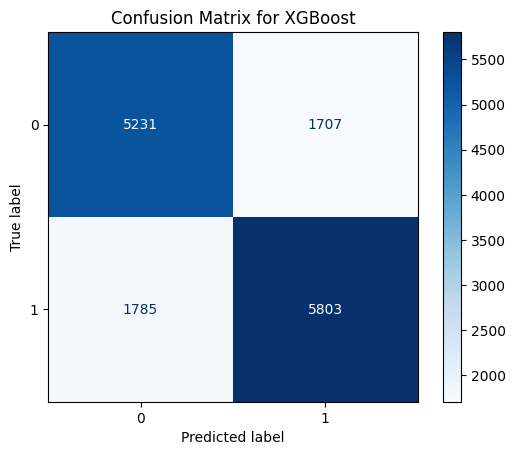

In [27]:

eval_df = pd.DataFrame(evaluation)
eval_df


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


In [25]:
stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_models['RandomForest']),
        ('gb', best_models['GradientBoosting']),
        ('xgb', best_models['XGBoost'])
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)


stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

print("\n Final Stacking Model Accuracy:", accuracy_score(y_test, y_pred))


 Final Stacking Model Accuracy: 0.7580201018862729


In [30]:
y_pred_stack = stacking_model.predict(X_test)
y_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

evaluation.append({
    'Model': 'Stacking Ensemble',
    'Accuracy': accuracy_score(y_test, y_pred_stack),
    'Precision': precision_score(y_test, y_pred_stack),
    'Recall': recall_score(y_test, y_pred_stack),
    'F1': f1_score(y_test, y_pred_stack),
    'ROC_AUC': roc_auc_score(y_test, y_proba_stack)
})



In [32]:
results_df = pd.DataFrame(evaluation).sort_values(by='F1', ascending=False).reset_index(drop=True)
print("Final Model Comparison:\n")
display(results_df)

Final Model Comparison:



,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,GradientBoosting,0.759053,0.769515,0.769109,0.769312,0.852026
1,XGBoost,0.759603,0.772703,0.764760,0.768711,0.852101
2,Stacking Ensemble,0.758020,0.768490,0.768187,0.768338,0.851633
3,RandomForest,0.750034,0.753686,0.774644,0.764022,0.838859


In [33]:
best_model_name = results_df.iloc[0]['Model']
print(f" Best Model Based on F1 Score: {best_model_name}")

if best_model_name == 'Stacking Ensemble':
    final_model = stacking_model
else:
    final_model = best_models[best_model_name]

joblib.dump(final_model, 'final_attrition_model.pkl')
print(" Final model saved as 'final_attrition_model.pkl'")

 Best Model Based on F1 Score: GradientBoosting
 Final model saved as 'final_attrition_model.pkl'
